In [1]:
# Imports:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from methods import *
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import torch
import os
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import time
from sklearn.impute import KNNImputer


train = r'data\train.csv'
test = r'data\test.csv'

In [2]:
#load the training set
data = pd.read_csv(train)

# drop names of passengers and ticket labels
data = data.drop(["Name","Ticket"], axis = 1)

# change cabin sections (letters) and change them to numerical data
data["Cabin"] = data["Cabin"].apply(lambda x: x if str(x)[0] == "n" else str(x)[0])
data["Cabin"] = data["Cabin"].apply(lambda x: cabinToFloat(x))

# change categorical data to numerical data
data["Sex"] = data["Sex"].apply(lambda x: 1 if x == 'male' else 0)
data["Embarked"] = data["Embarked"].apply(lambda x: condit(x))

# initialize imputer and fit it to the data
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric= 'nan_euclidean')
imputer.fit(data)
dataT = imputer.transform(data)

#convert the transformed data back into the correct data type, and 
data = pd.DataFrame(dataT, columns = imputer.get_feature_names_out())

data = normData(data)
data


,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,1.0,0.0,0.826913,0.737281,-0.576954,0.432550,-0.473408,-0.502163,-0.703923,-0.588003
1,2.0,1.0,-1.565228,-1.354813,0.623247,0.432550,-0.473408,0.786404,-2.014827,1.939303
2,3.0,1.0,0.826913,-1.354813,-0.276904,-0.474279,-0.473408,-0.488580,-0.703923,-0.588003
3,4.0,1.0,-1.565228,-1.354813,0.398209,0.432550,-0.473408,0.420494,-2.014827,-0.588003
4,5.0,0.0,0.826913,0.737281,0.398209,-0.474279,-0.473408,-0.486064,-0.703923,-0.588003
...,...,...,...,...,...,...,...,...,...,...
886,887.0,0.0,-0.369158,0.737281,-0.201892,-0.474279,-0.473408,-0.386454,0.024358,-0.588003
887,888.0,1.0,-1.565228,-1.354813,-0.801992,-0.474279,-0.473408,-0.044356,1.626575,-0.588003
888,889.0,0.0,0.826913,-1.354813,-0.186889,0.432550,2.007806,-0.176164,0.024358,-0.588003
889,890.0,1.0,-1.565228,0.737281,-0.276904,-0.474279,-0.473408,-0.044356,-2.014827,1.939303


In [3]:
#Similar process for the test set except now we are predicting the "Survived" status
dataTest = pd.read_csv(test)

dataTest = dataTest.drop(["Name","Ticket"], axis = 1)

dataTest["Cabin"] = dataTest["Cabin"].apply(lambda x: x if str(x)[0] == "n" else str(x)[0])
dataTest["Cabin"] = dataTest["Cabin"].apply(lambda x: cabinToFloat(x))

dataTest["Sex"] = dataTest["Sex"].apply(lambda x: 1 if x == 'male' else 0)
dataTest["Embarked"] = dataTest["Embarked"].apply(lambda x: condit(x))

# initialize imputer and fit it to the data
imputer = KNNImputer(n_neighbors = 5, weights = 'uniform', metric= 'nan_euclidean')
imputer.fit(dataTest)
dataT = imputer.transform(dataTest)

#convert the transformed data back into the correct data type, and 
dataTest = pd.DataFrame(dataT, columns = imputer.get_feature_names_out())

# normalize the data
dataTest = normData(dataTest)
dataTest

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,892.0,0.872436,0.755024,0.380459,-0.498872,-0.399769,-0.499095,0.183342,0.470352
1,893.0,0.872436,-1.321292,1.345487,0.616254,-0.399769,-0.513937,0.183342,-0.699928
2,894.0,-0.315441,0.755024,2.503521,-0.498872,-0.399769,-0.465832,-0.222144,0.470352
3,895.0,0.872436,0.755024,-0.198558,-0.498872,-0.399769,-0.484179,0.183342,-0.699928
4,896.0,0.872436,-1.321292,-0.584570,0.616254,0.619154,-0.419294,0.723989,-0.699928
...,...,...,...,...,...,...,...,...,...
413,1305.0,0.872436,0.755024,-0.545969,-0.498872,-0.399769,-0.495143,-0.357306,-0.699928
414,1306.0,-1.503319,-1.321292,0.727869,-0.498872,-0.399769,1.310014,-2.249572,1.640632
415,1307.0,0.872436,0.755024,0.689268,-0.498872,-0.399769,-0.509462,-0.357306,-0.699928
416,1308.0,0.872436,0.755024,-0.545969,-0.498872,-0.399769,-0.495143,-0.357306,-0.699928


In [4]:
x_train = (data).drop("Survived", axis = 1).drop("PassengerId", axis = 1)
y_train = (data)["Survived"]

x_test = dataTest.drop("PassengerId", axis = 1)

Progress: |██████████████████████████████████████████████████| 100.0% Complete


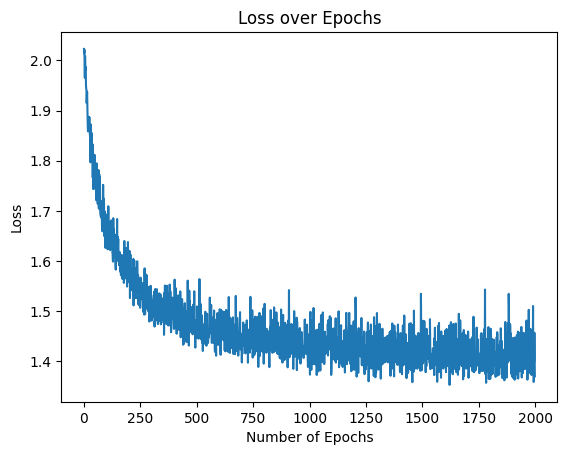

In [5]:
# Convert x_train and y_train DataFrames to NumPy arrays
x_train_np = x_train.values
y_train_np = y_train.values.flatten()  # Flatten to get a 1D array

# Convert NumPy arrays to tensors
x_train_tensor = torch.tensor(x_train_np, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_np, dtype=torch.long)

# Parameters
input_size = x_train_tensor.size(1)
output_size = 8  # Number of classes
batch_size = 32
learning_rate = .01
num_epochs = 2500

# Create DataLoader
train_dataset = torch.utils.data.TensorDataset(x_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# Build custom module for logistic regression
class LogisticRegression(torch.nn.Module):    
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.linear = torch.nn.Linear(n_inputs, n_outputs)
    
    def forward(self, x):
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred

# Instantiate the model
log_regr = LogisticRegression(input_size, output_size)

# Define the optimizer and loss function
optimizer = torch.optim.SGD(log_regr.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

# Training loop
Loss = []

l = num_epochs
printProgressBar(0,l,prefix = 'Progress:', suffix = 'Complete', length = 50)

for epoch in range(num_epochs):
    for i, (features, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = log_regr(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    
    Loss.append(loss.item())

    printProgressBar(epoch+1, l ,prefix = 'Progress:', suffix = 'Complete', length = 50)

# Plotting the loss
plt.plot(Loss)
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.title("Loss over Epochs")
plt.show()


In [6]:
# Convert x_test DataFrame to NumPy array
x_test_np = x_test.values

# Convert NumPy array to tensor
x_test_tensor = torch.tensor(x_test_np, dtype=torch.float32)

# Ensure the model is in evaluation mode
log_regr.eval()

# Make predictions
with torch.no_grad():
    test_outputs = log_regr(x_test_tensor)
    _, predicted_labels = torch.max(test_outputs.data, 1)

score = 0

# Print the predicted labels, batch size, learning rate, epochs, and score
print("Predicted labels for the test dataset:")
print(predicted_labels.numpy())
print()
print("batch = " + str(batch_size) + "\nlr = " + str(learning_rate) + "\nepochs = " + str(num_epochs) + "\n\nscore:" + "\n")

#write the output to a log file
with open("data/scorelog.txt","a") as f:
    f.write("\n")
    f.write(str(predicted_labels.numpy()))
    f.write("\n")
    f.write("batch = " + str(batch_size) + "\nlr = " + str(learning_rate) + "\nepochs = " + str(num_epochs) + "\n\nscore: " + "\n")

Predicted labels for the test dataset:
[0 0 0 0 1 0 1 0 1 0 0 0 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 0 0 0 0 0 1 0 1 0 1
 1 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0
 0 0 1 0 0 1 0 0 1 1 0 1 1 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 1 0 0 0 1 1 0 1 0 0 0 0 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 1 1 1 1 1 1 0 1 0 0 0]

batch = 32
lr = 0.01
epochs = 2000

score:



In [7]:
'''
# write the predicted labels to a .csv file to submit
out3 = pd.DataFrame({"PassengerId" : (int(x) for x in dataTest["PassengerId"]),"Survived" : (int(y) for y in predicted_labels)})
print(out3)
out3.to_csv('data\submission.csv', index = False)
'''

'\n# write the predicted labels to a .csv file to submit\nout3 = pd.DataFrame({"PassengerId" : (int(x) for x in dataTest["PassengerId"]),"Survived" : (int(y) for y in predicted_labels)})\nprint(out3)\nout3.to_csv(\'data\\submission.csv\', index = False)\n'